In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.base
import taichi as ti
import klib as kl
import warnings
import os

os.environ['KERAS_BACKEND']='tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Kaiti']
plt.rcParams['axes.unicode_minus'] = False
PIC_PATH = "../models/solve5/"
DATA_PATH = "../data/"
ti.init(arch=ti.gpu)

[Taichi] version 1.1.2, llvm 10.0.0, commit f25cf4a2, win, python 3.9.7
[Taichi] Starting on arch=cuda


In [2]:
from joblib import load

X = pd.read_csv(DATA_PATH + 'X.csv', index_col=0)
y = pd.read_csv(DATA_PATH + 'y.csv', index_col=0)
model = load(DATA_PATH + 'solve3.model')
y.index = X.index
X

,调和平均温度,扭矩转速积,机器质量等级,运行时间,温差
0,301.799801,15864.8,0,213.0,11.0
1,300.958445,94107.0,1,89.0,10.5
2,300.858415,33142.0,0,149.0,10.5
32,301.651566,90087.7,1,24.0,10.9
101,302.303571,78114.0,0,202.0,10.8
...,...,...,...,...,...
8756,304.096910,36790.2,0,218.0,11.2
8762,303.900493,86309.8,0,12.0,11.0
8820,303.852278,82824.0,0,187.0,10.9
8828,303.700428,75005.7,0,206.0,11.0


In [3]:
data = pd.concat([X, y], axis=1)
target = np.unique(y)
group = data.groupby('故障类别')
target

array(['HDF', 'OSF', 'PWF', 'RNF', 'TWF'], dtype=object)

In [4]:
columns = X.columns
numberic = columns.drop('机器质量等级')
target_column = numberic.copy().tolist()
target_column.append('故障类别')
numberic

Index(['调和平均温度', '扭矩转速积', '运行时间', '温差'], dtype='object')

In [5]:
data[target_column]

,调和平均温度,扭矩转速积,运行时间,温差,故障类别
0,301.799801,15864.8,213.0,11.0,PWF
1,300.958445,94107.0,89.0,10.5,PWF
2,300.858415,33142.0,149.0,10.5,PWF
32,301.651566,90087.7,24.0,10.9,PWF
101,302.303571,78114.0,202.0,10.8,OSF
...,...,...,...,...,...
8756,304.096910,36790.2,218.0,11.2,TWF
8762,303.900493,86309.8,12.0,11.0,PWF
8820,303.852278,82824.0,187.0,10.9,OSF
8828,303.700428,75005.7,206.0,11.0,OSF


In [8]:
description = pd.DataFrame(index=pd.MultiIndex.from_product(
    [target,
     ['调和平均温度', '扭矩转速积', '运行时间', '温差']]
))

def compute_cov(df):
    return df.std() / df.mean()

count = []
mean = []
median = []
maxin = []
cov = []
maxium = []
minin = []

for classes in target:
    _ = group.get_group(classes).drop(['故障类别', '机器质量等级'], axis=1)
    count.extend(_.count().tolist())
    mean.extend(_.mean().tolist())
    median.extend(_.median().tolist())
    maxin.extend(_.max() - _.min().tolist())
    cov.extend(compute_cov(_).tolist())
    maxium.extend(_.max().tolist())
    minin.extend(_.min().tolist())

description['count'] = count
description['mean'] = mean
description['median'] = median
description['cov'] = cov
description['maxin'] = maxin
description['max'] = maxium
description['min'] = minin

description.to_csv(DATA_PATH + 'solve3_description.csv')
description

count          mean        median       cov         maxin  \
HDF 调和平均温度     95    306.669773    306.493818  0.001964      2.251804   
    扭矩转速积      95  69825.557895  69379.200000  0.093503  27518.600000   
    运行时间       95    101.736842     93.000000  0.614684    217.000000   
    温差         95      8.207368      8.300000  0.033732      1.000000   
OSF 调和平均温度     85    305.211310    305.379211  0.005361      6.134039   
    扭矩转速积      85  78376.209412  78022.400000  0.083106  33867.600000   
    运行时间       85    206.929412    207.000000  0.076620     79.000000   
    温差         85      9.965882      9.900000  0.102289      3.600000   
PWF 调和平均温度     74    305.167422    305.687817  0.006119      7.673017   
    扭矩转速积      74  67029.317568  86465.450000  0.442873  86752.600000   
    运行时间       74     89.067568     90.000000  0.646396    215.000000   
    温差         74      9.777027      9.550000  0.105325      4.000000   
RNF 调和平均温度      6    305.996232    305.950236  0.003988      3.269478   
    扭矩转速积       6  61963.650000  65673.550000  0.175572  25208.700000   
    运行时间        6    107.000000    110.000000  0.515597    159.000000   
    温差          6      9.266667      9.400000  0.068478      1.900000   
TWF 调和平均温度     41    305.423388    305.593719  0.005019      6.376369   
    扭矩转速积      41  57803.190244  57825.000000  0.190678  52279.000000   
    运行时间       41    216.707317    215.000000  0.058536     55.000000   
    温差         41      9.841463      9.600000  0.111887      3.700000   

                     max           min  
HDF 调和平均温度    307.842709    305.590905  
    扭矩转速积   83990.400000  56471.800000  
    运行时间      219.000000      2.000000  
    温差          8.600000      7.600000  
OSF 调和平均温度    308.385800    302.251761  
    扭矩转速积   99980.400000  66112.800000  
    运行时间      251.000000    172.000000  
    温差         11.400000      7.800000  
PWF 调和平均温度    308.531432    300.858415  
    扭矩转速积   97719.400000  10966.800000  
    运行时间      215.000000      0.000000  
    温差         11.600000      7.600000  
RNF 调和平均温度    307.645369    304.375891  
    扭矩转速积   73602.000000  48393.300000  
    运行时间      179.000000     20.000000  
    温差         10.100000      8.200000  
TWF 调和平均温度    308.980036    302.603667  
    扭矩转速积   89069.200000  36790.200000  
    运行时间      253.000000    198.000000  
    温差         11.500000      7.800000

In [9]:
import shap

exp = shap.TreeExplainer(model)
shap_values = exp.shap_values(X)
shap_values2 = exp(X)

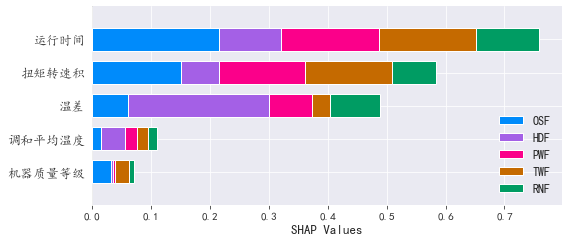

In [10]:
plt.cla()
shap.summary_plot(shap_values, X, show=False, class_names=target)
plt.tight_layout()
plt.xlabel('SHAP Values')
plt.savefig(PIC_PATH + 'feature impact.png', dpi=800)

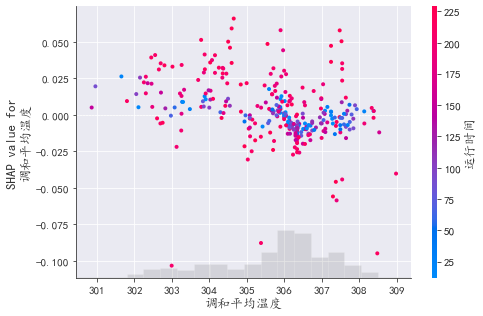

In [36]:
shap_values2.display_data = X.values
shap.plots.scatter(shap_values2[:, '调和平均温度'][:, 1], color=shap_values2[:, '运行时间'][:, 1], show=False)
plt.savefig(PIC_PATH + 'temp-time-shap.png', dpi=800)

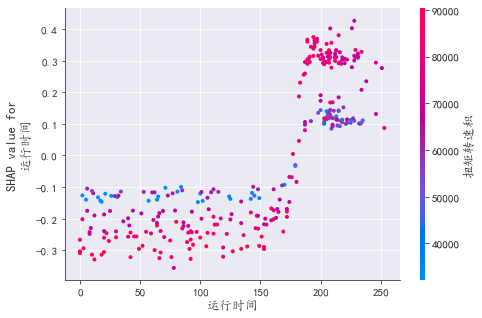

In [38]:
shap.dependence_plot("运行时间", shap_values[1], X, show=False)
plt.savefig(PIC_PATH + 'shap time-npm.png', dpi=800)

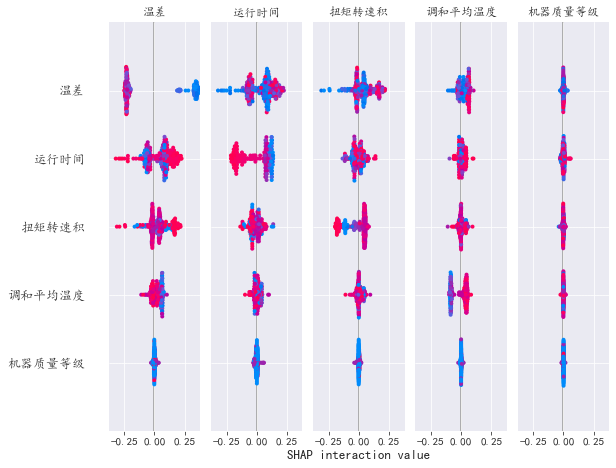

In [11]:
shap_interaction_values = exp.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values[0], X, show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'interaction values ' + target[0] + '.png', dpi=800)

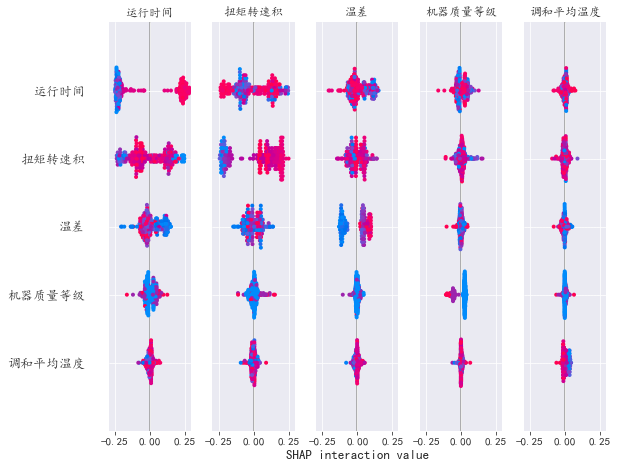

In [12]:
shap_interaction_values = exp.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values[1], X, show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'interaction values ' + target[1] + '.png', dpi=800)

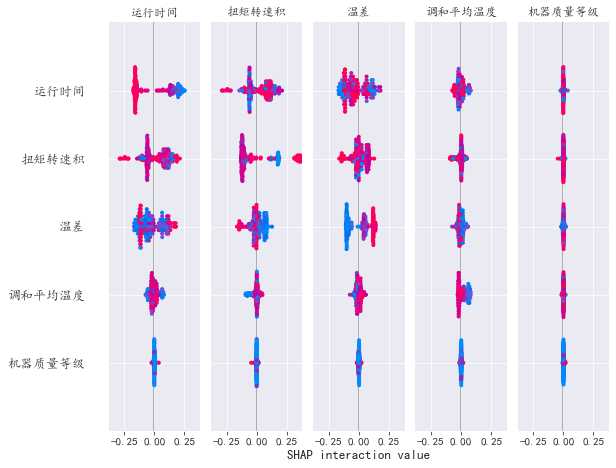

In [13]:
shap_interaction_values = exp.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values[2], X, show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'interaction values ' + target[2] + '.png', dpi=800)

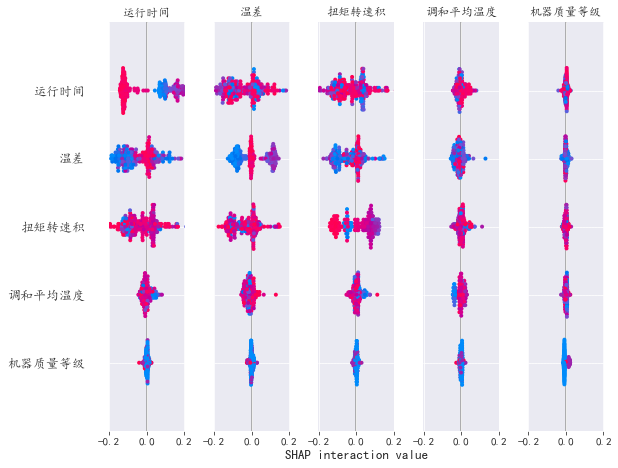

In [14]:
shap_interaction_values = exp.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values[3], X, show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'interaction values ' + target[3] + '.png', dpi=800)

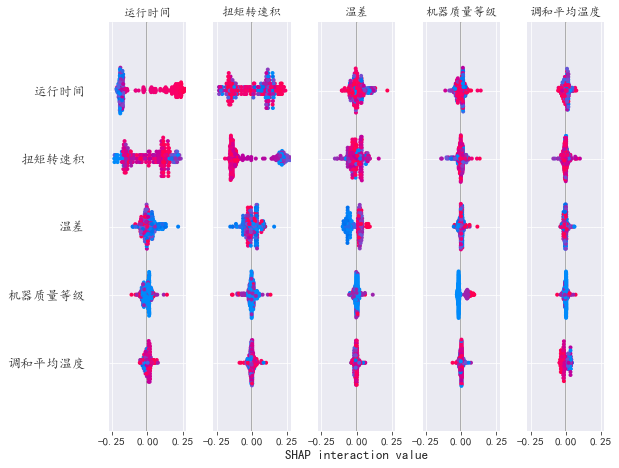

In [15]:
shap_interaction_values = exp.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values[4], X, show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'interaction values ' + target[4] + '.png', dpi=800)

In [16]:
expected_value = exp.expected_value

y_pred = (np.array(shap_values).sum(1) + expected_value) > 0
y_pred

array([[ True, False,  True,  True,  True],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

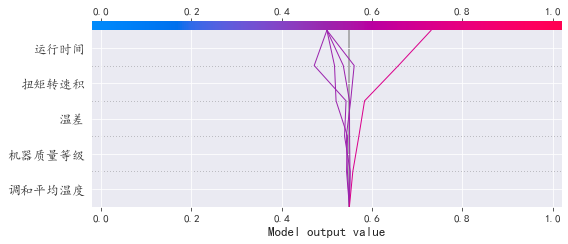

In [39]:
shap.multioutput_decision_plot(
    expected_value,
    shap_values,
    row_index=30,
    feature_names=columns.tolist(),
    link='logit',
    show=False,
    # legend_labels=target,
    # legend_location='upper right'
)
plt.tight_layout()
plt.savefig(PIC_PATH + 'decision plot.png', dpi=800)

In [29]:
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison

def my_oneWayAnova(df,cata_name,num_name,alpha_anova=0.05,alpha_tukey=0.05):

    df[cata_name]=df[cata_name].astype('str')

    s1=df[cata_name]
    s2=df[num_name]

    fml=num_name+'~C('+cata_name+')'

    model = ols(fml,data=df).fit()
    anova_table_1 = anova_lm(model, typ = 2).reset_index()
    p1=anova_table_1.loc[0,'PR(>F)']

    #输出 ： 是否相等【不等式序列】
    if p1>alpha_anova:
        print(num_name + '组间【无】显著差异')
    else:
        print(num_name + '组间【有】显著差异')
        #输出不等式

    df_p1=df.groupby([cata_name])[num_name].describe()

    # 输出： Tudey 多重比较
    mc = MultiComparison(df[num_name],df[cata_name])
    df_smry = mc.tukeyhsd(alpha=alpha_tukey).summary()
    m = np.array(df_smry.data)
    df_p2 =pd.DataFrame(m[1:],columns=m[0])

    df_p1_sub=df_p1[['mean']].copy()
    df_p1_sub.sort_values(by='mean',inplace=True)

    output_list=[]

    for x in range(1,len(df_p1_sub.index)):
        if (df_p2.loc[((df_p2.group1==df_p1_sub.index[x-1])&(df_p2.group2==df_p1_sub.index[x]))|
                      ((df_p2.group1==df_p1_sub.index[x])&(df_p2.group2==df_p1_sub.index[x-1])),
                      'reject'].iloc[0])=="True":
            smb='<'
        else:
            smb='<='
        if x==1:
            output_list.append(df_p1_sub.index[x-1])
            output_list.append(smb)
            output_list.append(df_p1_sub.index[x])
        else:
            output_list.append(smb)
            output_list.append(df_p1_sub.index[x])
    out_sentence=' '.join(output_list)
    print(out_sentence)

    return df_p1,df_p2

In [19]:
data

,调和平均温度,扭矩转速积,机器质量等级,运行时间,温差,故障类别
0,301.799801,15864.8,0,213.0,11.0,PWF
1,300.958445,94107.0,1,89.0,10.5,PWF
2,300.858415,33142.0,0,149.0,10.5,PWF
32,301.651566,90087.7,1,24.0,10.9,PWF
101,302.303571,78114.0,0,202.0,10.8,OSF
...,...,...,...,...,...,...
8756,304.096910,36790.2,0,218.0,11.2,TWF
8762,303.900493,86309.8,0,12.0,11.0,PWF
8820,303.852278,82824.0,0,187.0,10.9,OSF
8828,303.700428,75005.7,0,206.0,11.0,OSF


In [46]:
excel = pd.DataFrame()

for col in numberic:
    d1, d2 = my_oneWayAnova(data, cata_name='故障类别', num_name=col)
    d2['target'] = col
    excel = pd.concat([excel, d2], axis=0)
    print(d2)
excel.to_excel(DATA_PATH + 'ANOVA.xlsx')

调和平均温度组间【有】显著差异
PWF <= OSF <= TWF <= RNF <= HDF
  group1 group2 meandiff   p-adj    lower    upper reject  target
0    HDF    OSF  -1.4585     0.0  -2.0491  -0.8678   True  调和平均温度
1    HDF    PWF  -1.5024     0.0  -2.1158  -0.8889   True  调和平均温度
2    HDF    RNF  -0.6735  0.8012  -2.3389   0.9918  False  调和平均温度
3    HDF    TWF  -1.2464  0.0001  -1.9857  -0.5071   True  调和平均温度
4    OSF    PWF  -0.0439  0.9997  -0.6729   0.5851  False  调和平均温度
5    OSF    RNF   0.7849  0.6981  -0.8863   2.4561  False  调和平均温度
6    OSF    TWF   0.2121   0.938  -0.5402   0.9643  False  调和平均温度
7    PWF    RNF   0.8288  0.6572  -0.8505   2.5082  False  调和平均温度
8    PWF    TWF    0.256  0.8921  -0.5143   1.0262  False  调和平均温度
9    RNF    TWF  -0.5728  0.8932  -2.3021   1.1565  False  调和平均温度
扭矩转速积组间【有】显著差异
TWF <= RNF <= PWF <= HDF < OSF
  group1 group2     meandiff   p-adj        lower        upper reject target
0    HDF    OSF    8550.6515  0.0042    1926.3196   15174.9834   True  扭矩转速积
1    HDF    PWF   -2796.24